# Custom Reports

In this notebook we'll explain, with examples, how to create customized reports of the Nested CV procedure. 

## Imports

In [31]:
import sys
sys.path.append('..')
import numpy as np, pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from nestedcvtraining.api import find_best_model
from nestedcvtraining.switch_case import SwitchCase
from nestedcvtraining.under_sampling_classifier import UnderSamplingClassifier
from skopt import gbrt_minimize
from collections import Counter
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

## Dataset

We will use a dataset for multiclass classification and strong imbalance problem. 

In [2]:
dataset = pd.read_csv(
    "https://raw.githubusercontent.com/JaimeArboleda/nestedcvtraining/master/datasets/new-thyroid.csv", header=None
)
values = dataset.values
X, y = values[:, :-1], (values[:, -1] - 1).astype(int)


In [5]:
Counter(y)

Counter({0: 150, 1: 35, 2: 30})

## Model


In [6]:
resampler = SwitchCase(
    cases=[
        (
            "resampler_1",
            SMOTE(k_neighbors=3)
        ),
        (
            "resampler_2",
            "passthrough"
        )
    ],
    switch="resampler_1"
)

preprocessor = SwitchCase(
    cases=[
        (
            "prep_1",
            SkPipeline([
                ("scale", StandardScaler()), 
                ("reduce_dims", PCA(n_components=5))
            ])
        ),
        (
            "prep_2",
            SkPipeline([
                ("scale", StandardScaler()), 
                ("reduce_dims", SelectKBest(mutual_info_classif, k=5)),
            ])
        ),
        (
            "prep_3",
            StandardScaler()
        )
    ],
    switch="prep_1"
)

model = SwitchCase(
    cases=[
        (
            "model_1",
            LogisticRegression()
        ),
        (
            "model_2",
            RandomForestClassifier()
        )
    ],
    switch="model_1"
)

clf = ImbPipeline(
    [("resampler", resampler), ("preprocessor", preprocessor), ("model", model)]
)

search_space= [
    Categorical(["resampler_1", "resampler_2"], name="resampler__switch"),
    Categorical(["prep_1", "prep_2", "prep_3"], name="preprocessor__switch"),
    Categorical(["model_1", "model_2"], name="model__switch"),
    Categorical(["minority", "all"], name="resampler__resampler_1__sampling_strategy"),
    Integer(5, 15, name="model__model_2__max_depth"),
    Categorical(["balanced", None], name="model__model_2__class_weight")
]

In [7]:
best_model, best_params, report = find_best_model(
    X=X,
    y=y,
    model=clf,
    search_space=search_space,
    verbose=False,
    k_inner=8,
    k_outer=8,
    n_initial_points=10,
    n_calls=10,
    calibrate="only_best",
    calibrate_params={"cv": 8, "method": "sigmoid"},
    optimizing_metric=make_scorer(roc_auc_score, average='weighted', multi_class='ovr', needs_proba=True),
    other_metrics={"acc": "accuracy"},
    skopt_func=gbrt_minimize
)

Looping over 0 outer fold
Looping over 1 outer fold
Looping over 2 outer fold
Looping over 3 outer fold
Looping over 4 outer fold
Looping over 5 outer fold
Looping over 6 outer fold
Looping over 7 outer fold


In [8]:
report.get_outer_metrics_report()

{'acc': {'mean': 0.8974358974358974,
  'sd': 0.08061973331527647,
  'min': 0.7777777777777778,
  'max': 1.0},
 'optimizing_metric': {'mean': 0.9883553890196402,
  'sd': 0.01832588611848996,
  'min': 0.9418896321070235,
  'max': 1.0}}

## Plotting the probability calibration curves

As an example, let's plot the calibration curves of all 8 inner best models trained during the outer loop.  

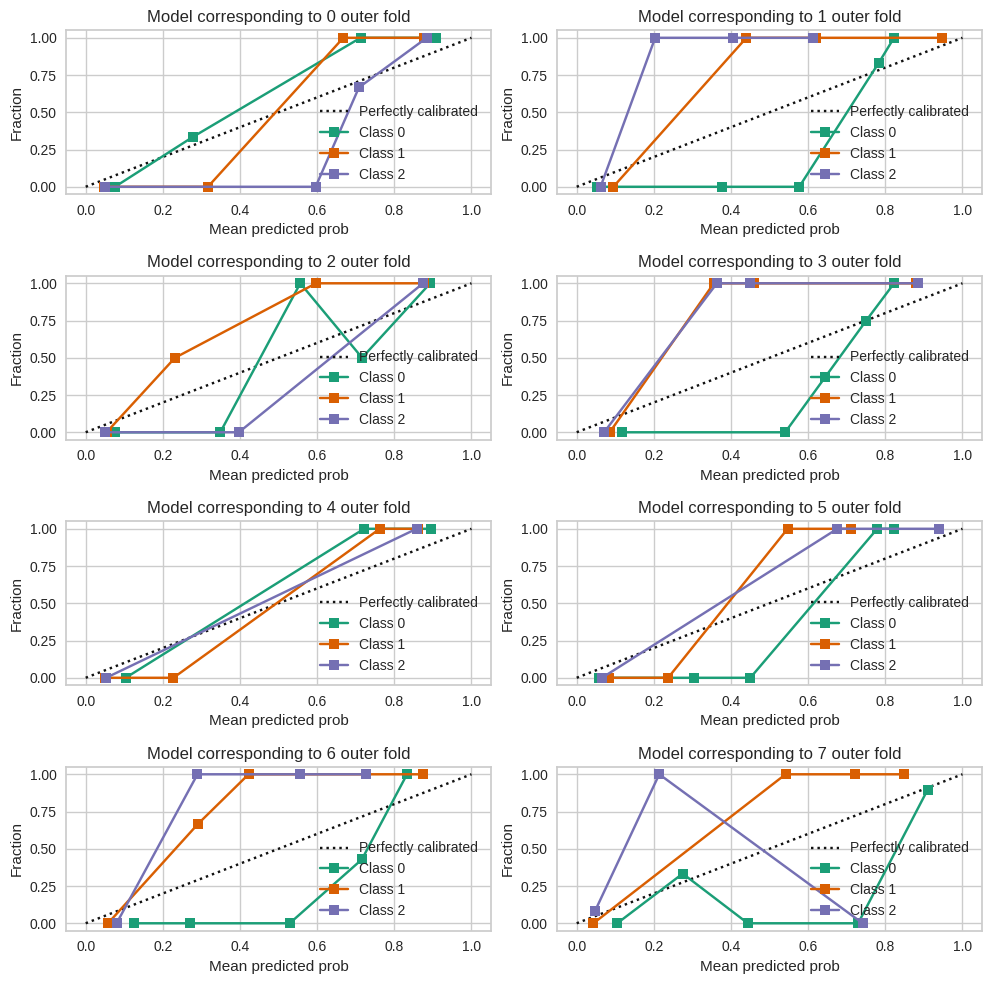

In [28]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
classes = [0, 1, 2]


grid_positions = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
i = 0
for model, test_idxs in report.iter_models_test_idxs():
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    # CalibrationDisplay does not work for multiclass, so we need to make some manual changes
    # We will plot One-Versus-Rest calibration curves for each model
    y_test_proba = model.predict_proba(X[test_idxs])
    for y_class in classes:
        y_test = (y[test_idxs] == y_class)
        y_proba = y_test_proba[:, y_class]
        CalibrationDisplay.from_predictions(
            y_test,
            y_proba,
            n_bins=5,
            name=f"Class {y_class}",
            ax=ax,
            color=colors(y_class)
        )  
    ax.set(title=f"Model corresponding to {i} outer fold", xlabel="Mean predicted prob", ylabel="Fraction")
    i += 1

plt.tight_layout()
plt.show()

The results look not very promising!! 

But the point of this example is to show how to do it. The problem we observe, and the reason for this huge variability, is that we have a very small test set (only 26 examples for each fold, shared among three classes). 

## Plotting the ROC AUC curves

Let's show now how to plot the ROC curves for each model. In this case we will use a handy library called `yellowbrick`.  

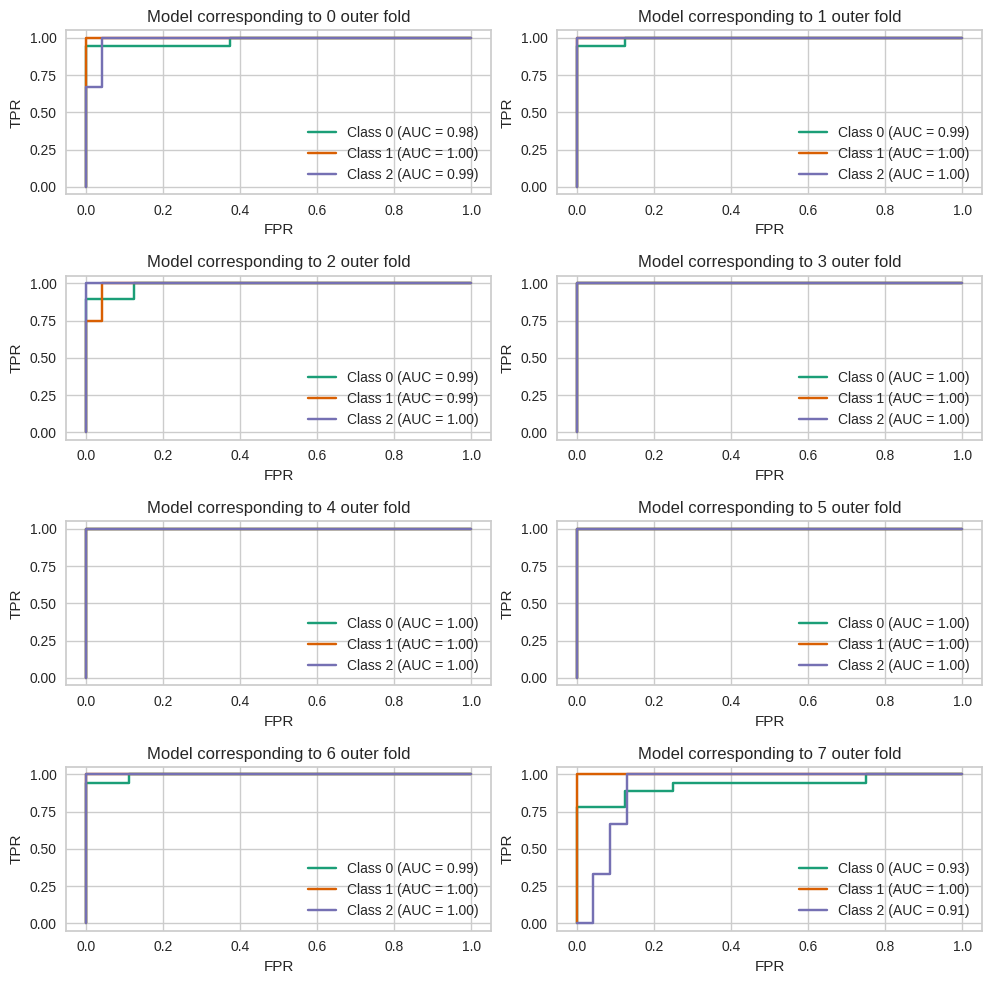

In [32]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
classes = [0, 1, 2]


grid_positions = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
i = 0
for model, test_idxs in report.iter_models_test_idxs():
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    # CalibrationDisplay does not work for multiclass, so we need to make some manual changes
    # We will plot One-Versus-Rest calibration curves for each model
    y_test_proba = model.predict_proba(X[test_idxs])
    for y_class in classes:
        y_test = (y[test_idxs] == y_class)
        y_proba = y_test_proba[:, y_class]
        RocCurveDisplay.from_predictions(
            y_test,
            y_proba,
            name=f"Class {y_class}",
            ax=ax,
            color=colors(y_class)
        )  
    ax.set(title=f"Model corresponding to {i} outer fold", xlabel="FPR", ylabel="TPR")
    i += 1

plt.tight_layout()
plt.show()

Again, we don't have enough examples to have nice curves...